Note: This notebook needs to be run with a GPU

In [1]:
import sys
from pathlib import Path
import os 
#sys.path.append('/home/gridsan/vyuan/.local/lib/python3.9/site-packages/')

current_path = Path.cwd()

# Go to top of the root and append
root = current_path.parents[3]
sys.path.append(str(root))

os.chdir(root)

In [35]:
import torch
import os
import random
import json
from pathlib import Path
import numpy as np
from PIL import Image

from fairness_cv_project.methods_mscoco.label_free_cbm.src.plots import plots
from fairness_cv_project.methods_mscoco.label_free_cbm.src.utils import data_utils, utils
from fairness_cv_project.methods_mscoco.label_free_cbm.src.models import cbm

In [3]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/mscoco/single_label/CBM/balanced_sparse/mscoco_single_balanced_mscoco_single_filtered"
path_model_dir = root / load_dir
device = "cuda" if torch.cuda.is_available() else 'cpu'


with open(root / os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
    
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device, root)
model = cbm.load_cbm(path_model_dir, device)

In [4]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

loading annotations into memory...
1868 annotations loaded
loading annotations into memory...
1868 annotations loaded


In [5]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [6]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

Accuracy: 73.98%


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [8]:
model.final.weight[9]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0522,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1674,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0656,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0006,
         0.0000,  0.0000,  0.1086,  0.0906,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0137,  0.0000,  0.0000,  0.0000,  0.6102,  0.0000,  0.0000,  0.0000,
         0.0266,  0.0000,  0.0000,  0.0000,  0.0000, -0.1382,  0.0000,  0.0000,
         0.3351,  0.0000,  0.0000,  0.1652,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -0.1424,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [9]:
to_show = random.choices([i for i in range(len(classes))], k=2)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:5 - skis
Incoming weights:
A ski lift [0.2399] skis
A ski patrol [0.3193] skis
A ski resort [0.1173] skis
A ski slope [0.1719] skis
Ski equipment [0.2916] skis
a bottle of milk [-0.0687] skis
a ski lodge [0.1991] skis
a ski rental shop [0.0928] skis
a ski school [0.3065] skis
snow [0.1177] skis
used for sliding on snow [0.1484] skis
Output class:7 - bed
Incoming weights:
a bedside table [0.3966] bed
a bedspread [0.3984] bed
a comforter [0.1859] bed
a mattress [0.1796] bed
a pillow [0.0674] bed
may have a mattress [0.1060] bed
may have sheets [0.2840] bed
pillows and blankets [0.2896] bed


In [10]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 3 - surfboard
Highest weights: a surfboard rack:0.540, a surfboard wax:0.485, a wave:0.334, used for surfing:0.332, a wetsuit:0.156, 
Lowest weights: A ski patrol:0.000, A ski lift:0.000, A ski resort:0.000, Ski equipment:0.000, A ski slope:0.000, 

Class 4 - bottle
Highest weights: a bottle of juice:0.342, a table:0.298, a conveyor belt:0.256, cans:0.241, a bottle of soda:0.155, 
Lowest weights: a charger:-0.224, a pole:-0.126, an earphone:-0.116, a pillow:-0.052, a driver:-0.044, 



In [11]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:110/132


## Explain model reasoning for random inputs

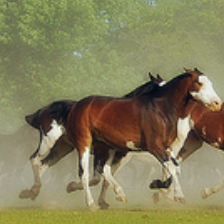

Image:1364 Gt:horse, 1st Pred:horse, 5.257, 2nd Pred:chair, 1.327


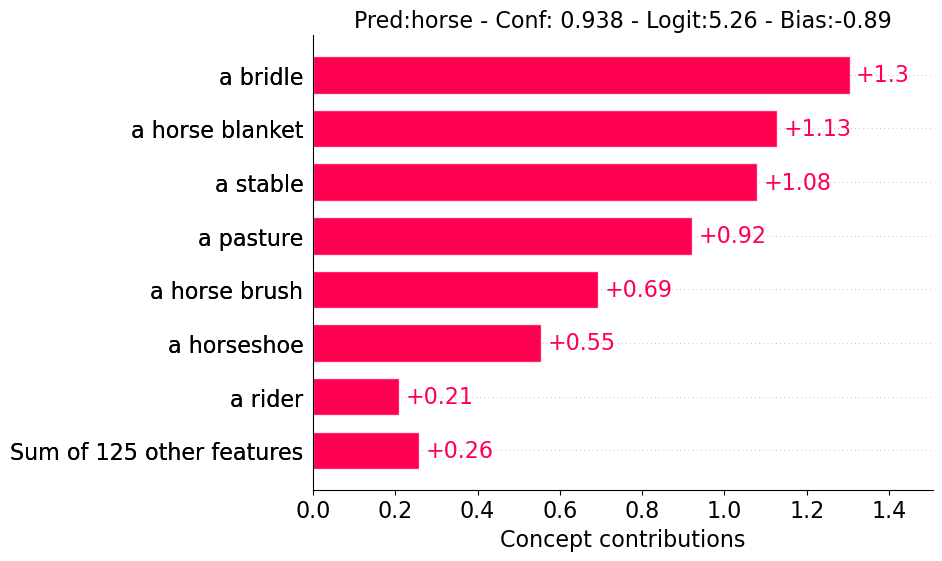

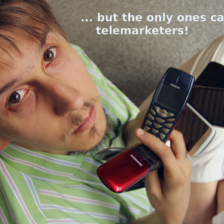

Image:751 Gt:cell phone, 1st Pred:cell phone, 2.610, 2nd Pred:bed, 1.471


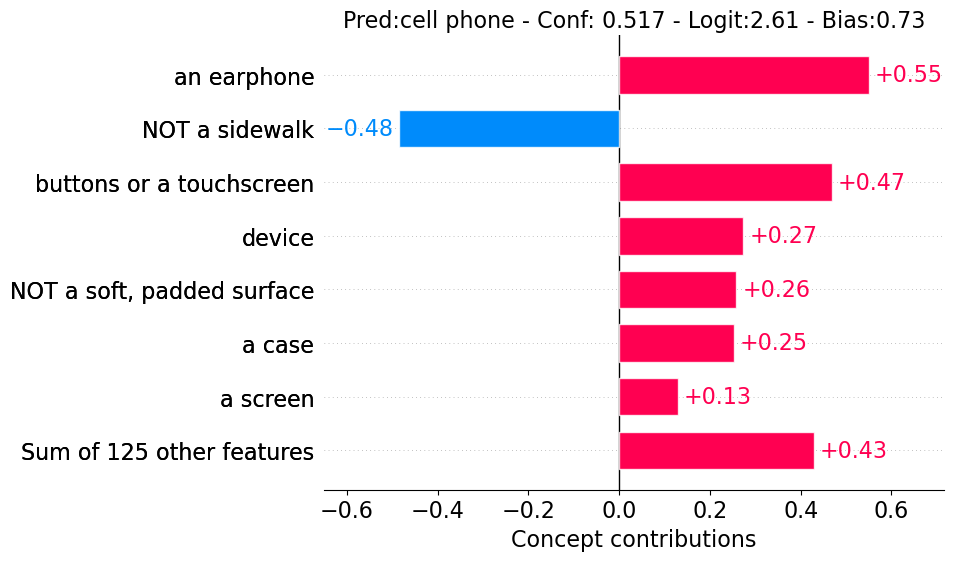

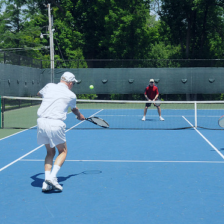

Image:18 Gt:tennis racket, 1st Pred:tennis racket, 4.704, 2nd Pred:car, 1.293


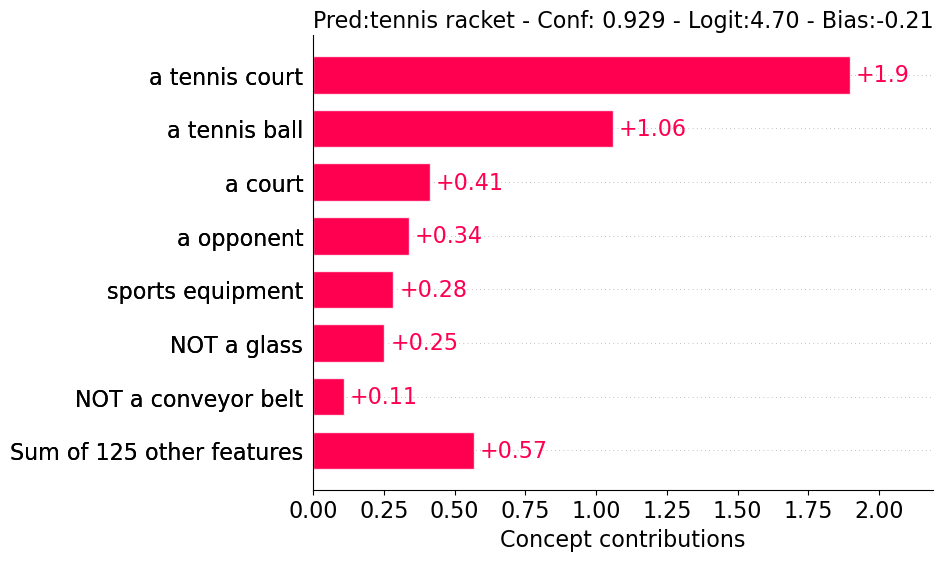

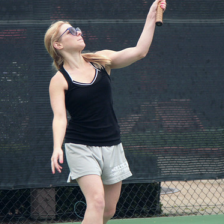

Image:261 Gt:tennis racket, 1st Pred:tennis racket, 3.744, 2nd Pred:car, 0.371


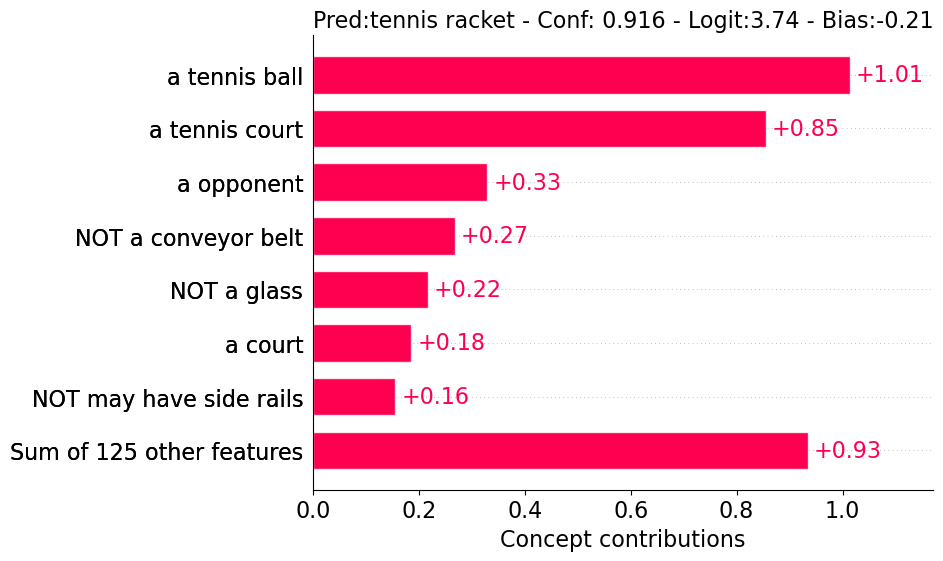

In [37]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        image.to(device)
        x = x.unsqueeze(0).to(device)
        image = (image - image.min()) / (image.max() - image.min()) * 255
        image = image.to(torch.uint8)
        image = Image.fromarray(image.permute(1, 2, 0).numpy())
        display(image)
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)